<a href="https://colab.research.google.com/github/dev02chandan/HAR-POC/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## rvv-karma/Human-Action-Recognition-VIT-Base-patch16-224

Here is how to use this model to classify an image of the human action into one of the following categories:

**```calling, clapping, cycling, dancing, drinking, eating, fighting, hugging, laughing, listening_to_music, running, sitting, sleeping, texting, using_laptop```**

#### Image

In [1]:
from transformers import pipeline
from PIL import Image
import requests

In [2]:
pipe = pipeline("image-classification", "rvv-karma/Human-Action-Recognition-VIT-Base-patch16-224")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [3]:
url = "https://images.pexels.com/photos/175658/pexels-photo-175658.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500"

In [4]:
image = Image.open(requests.get(url, stream=True).raw)

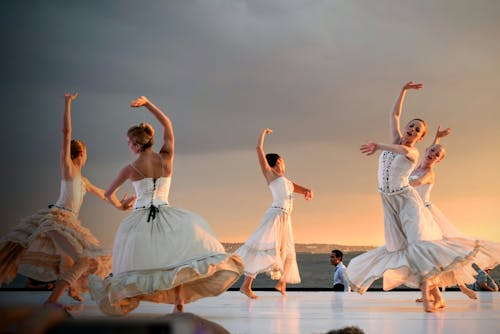

In [5]:
image

In [6]:
pipe(image)

[{'label': 'Dancing', 'score': 0.9918228983879089},
 {'label': 'Clapping', 'score': 0.0022566700354218483},
 {'label': 'Running', 'score': 0.0014649414224550128},
 {'label': 'Fighting', 'score': 0.0008779013296589255},
 {'label': 'Sitting', 'score': 0.0007207177695818245}]

#### Video

In [7]:
import cv2
from transformers import pipeline
from PIL import Image
import numpy as np
import torch
import os

In [8]:
# Initialize the pipeline with the pre-trained model
pipe = pipeline("image-classification", "rvv-karma/Human-Action-Recognition-VIT-Base-patch16-224", device=0 if torch.cuda.is_available() else -1)

In [9]:
# Function to process frames
def process_frame(frame):
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return pipe(image)

In [10]:
# Open the video file
video_path = '/content/drive/MyDrive/Internship/HAR 1.mov'
cap = cv2.VideoCapture(video_path)

In [11]:
# Check if video opened successfully
if not cap.isOpened():
    print("Error opening video stream or file")

In [12]:
# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

In [13]:
(frame_width, frame_height)

(1920, 1080)

In [14]:
fps

23

In [15]:
# Define the codec and create VideoWriter object
# out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'MP4V'), fps, (frame_width, frame_height))
out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'MJPG'), fps, (frame_width, frame_height))

In [16]:
# Process video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        # Process the frame
        result = process_frame(frame)
        # Get the most likely activity
        top_result = result[0]
        label = top_result['label']
        score = top_result['score']
        # Annotate the frame with the activity label
        text = f'{label}: {score:.2f}'
        font = cv2.FONT_HERSHEY_SIMPLEX
        text_size = cv2.getTextSize(text, font, 1, 2)[0]
        text_x = (frame.shape[1] - text_size[0]) // 2
        text_y = frame.shape[0] - 30
        cv2.putText(frame, text, (text_x, text_y), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
        # Write the frame into the file
        out.write(frame)
    else:
        break

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


`Above cell took 1m 27s (97s) to process and write 105 frames on colab cpu`

In [17]:
!cp output_video.mp4 /content/drive/MyDrive/Internship/output_video.mp4

In [18]:
# Release everything when the job is finished
cap.release()
out.release()

In [24]:
import cv2
from transformers import pipeline
from PIL import Image
import numpy as np
import torch
import time
from IPython.display import HTML
from base64 import b64encode

# Initialize the pipeline with the pre-trained model
pipe = pipeline("image-classification", "rvv-karma/Human-Action-Recognition-VIT-Base-patch16-224", device=0 if torch.cuda.is_available() else -1)

def process_and_annotate_video(input_video_path, output_video_path):
    # Open the video file
    cap = cv2.VideoCapture(input_video_path)

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define the codec and create VideoWriter object
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    # Check if video opened successfully
    if not cap.isOpened():
        print("Error opening video stream or file")
        return

    frame_count = 0  # Frame counter for debugging

    # Process video frame by frame
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frame_count += 1
            # Process the frame
            result = process_frame(frame)
            # Determine the number of labels to show based on the top prediction's score
            top_score = result[0]['score']
            if top_score > 0.8:
                num_labels = 1
            elif 0.5 < top_score <= 0.8:
                num_labels = 2
            else:
                num_labels = 3

            # Create the text to annotate on the frame
            text = ', '.join([f"{result[i]['label']}: {result[i]['score']:.2f}" for i in range(min(num_labels, len(result)))])

            # Annotate the frame with the activity labels
            font = cv2.FONT_HERSHEY_SIMPLEX
            text_size = cv2.getTextSize(text, font, 1, 2)[0]
            text_x = (frame.shape[1] - text_size[0]) // 2
            text_y = frame.shape[0] - 30
            cv2.putText(frame, text, (text_x, text_y), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

            # Write the frame into the file
            out.write(frame)
        else:
            break

    print(f'Total frames processed: {frame_count}')

    # Release everything when the job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    # Ensure the file is fully written by adding a short delay
    time.sleep(2)

    # Display the annotated video
    display_video(output_video_path)

# Helper function to process frames
def process_frame(frame):
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return pipe(image)

# Function to display the video in Colab
def display_video(video_path):
    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f"""
    <video width=600 controls>
          <source src="{data_url}" type="video/mp4">
    </video>
    """)


In [25]:
# Example usage
input_video_path = '/content/drive/MyDrive/Internship/HAR 1.mov'
output_video_path = '/content/drive/MyDrive/Internship/output_video2.mov'
process_and_annotate_video(input_video_path, output_video_path)

Total frames processed: 1705
